The aim is to predict the next day returns knowing all the information before opening the market

In [1]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import cufflinks as cf
from pandas_datareader import data
from pandas.tseries.frequencies import to_offset
import csv
from datetime import datetime
import time

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [3]:
from ipynb.fs.full.my_functions import data_agreggation_yahoo
from ipynb.fs.full.my_functions import data_agreggation_csv

# 1. Data Preparation

## 1.1. Loading S&P500 DATA

In [4]:
#training
start = '2002-06-01'
end = '2022-06-01'

In [5]:
df = yf.download("^GSPC", start = start, end = end, parse_dates=['date'])
df.drop(["Adj Close"],axis=1,inplace=True)

[*********************100%***********************]  1 of 1 completed


## 1.2. Calculating Next Day Return for Classification

In [6]:
#I want to predict
df["simple_daily_returns"] = (df.Close - df.Open) / df.Open
df["log_daily_returns"] = np.log(df.Open/df.Close)
#Shift 1 value
df["Y_next_daily_returns"] = df["simple_daily_returns"].shift(-1)

In [7]:
df.head(3)

,Open,High,Low,Close,Volume,simple_daily_returns,log_daily_returns,Y_next_daily_returns
Date,,,,,,,,
2002-05-31,1064.660034,1079.930054,1064.660034,1067.140015,1277300000,0.002329,-0.002327,-0.024795
2002-06-03,1067.140015,1070.739990,1039.900024,1040.680054,1324300000,-0.024795,0.025108,0.000010
2002-06-04,1040.680054,1046.060059,1030.520020,1040.689941,1466600000,0.000010,-0.000010,0.008850


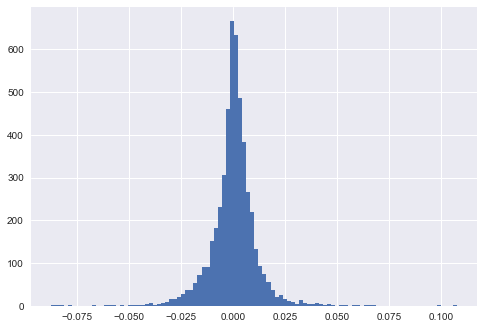

In [8]:
x = df["simple_daily_returns"]
plt.hist(x, bins = 100)
plt.show()

In [9]:
df= df[ ["simple_daily_returns"] + [ col for col in df.columns if col != "simple_daily_returns" ]]
df= df[ ["Y_next_daily_returns"] + [ col for col in df.columns if col != "Y_next_daily_returns" ]]

## 1.3. Is it the station important?

In [10]:
df['day-of-week'] = df.index.dayofweek
df['week-of-year'] = df.index.weekofyear
df['month-of-year'] = df.index.month

C:\Users\PCALAT~1\AppData\Local\Temp/ipykernel_15836/3401832936.py:2: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



## 1.3. Calculating Day volatility in %

In [11]:
df["day_volatility_%"]=(df["High"]-df["Low"])/df["Low"]

In [12]:
df.head(3)

,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%
Date,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1064.660034,1079.930054,1064.660034,1067.140015,1277300000,-0.002327,4,22,5,0.014343
2002-06-03,0.000010,-0.024795,1067.140015,1070.739990,1039.900024,1040.680054,1324300000,0.025108,0,23,6,0.029657
2002-06-04,0.008850,0.000010,1040.680054,1046.060059,1030.520020,1040.689941,1466600000,-0.000010,1,23,6,0.015080


## 1.4. Dropping Open, High, Low

In [13]:
df = df.drop(["Open","Low","High"], axis='columns')

In [14]:
df.head(3)

,Y_next_daily_returns,simple_daily_returns,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%
Date,,,,,,,,,
2002-05-31,-0.024795,0.002329,1067.140015,1277300000,-0.002327,4,22,5,0.014343
2002-06-03,0.000010,-0.024795,1040.680054,1324300000,0.025108,0,23,6,0.029657
2002-06-04,0.008850,0.000010,1040.689941,1466600000,-0.000010,1,23,6,0.015080


# 2. Agreggating Macro-Factor returns

Let's continue with the macro factors

## 2.1. Gold Price

Gold oz can be traded at any hour. So open and close prices are just the price for a fixed time

In [15]:
gold_oz = yf.download("GC=F", start = start, end = end)
gold_oz["gold_returns"] = (gold_oz.Close - gold_oz.Open) / gold_oz.Open
df["gold_returns"]=gold_oz["gold_returns"]
df.head(4)

[*********************100%***********************]  1 of 1 completed


,Y_next_daily_returns,simple_daily_returns,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns
Date,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615
2002-06-03,0.000010,-0.024795,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306
2002-06-04,0.008850,0.000010,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446
2002-06-05,-0.019764,0.008850,1049.900024,1300100000,-0.008811,2,23,6,0.010849,-0.018637


## 2.2. Oil Price

WTI can be traded at any hour. Because of that it is possible to get the information from open to open of next day

In [16]:
oil = yf.download("CL=F", start = start, end = end)
oil["oil_returns"] = (oil.Close - oil.Open) / oil.Open
df["oil_returns"] = oil["oil_returns"]
df.head(4)

[*********************100%***********************]  1 of 1 completed


,Y_next_daily_returns,simple_daily_returns,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,oil_returns
Date,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615,0.018072
2002-06-03,0.000010,-0.024795,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306,-0.005938
2002-06-04,0.008850,0.000010,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446,0.009980
2002-06-05,-0.019764,0.008850,1049.900024,1300100000,-0.008811,2,23,6,0.010849,-0.018637,0.003629


## 2.3. Yield Price - 13 weeks

It is calculated the daily return for open/close price

### Sometimes this ticker is not available in yahoo finance

In [17]:
treasury_13w = yf.download("^IRX", start = start, end = end)
treasury_13w["13w_yield_returns"] = (treasury_13w.Close - treasury_13w.Open) / treasury_13w.Open
df["treasury_13w_returns"]=treasury_13w["13w_yield_returns"]
df.head(4)

[*********************100%***********************]  1 of 1 completed


,Y_next_daily_returns,simple_daily_returns,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,oil_returns,treasury_13w_returns
Date,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615,0.018072,-0.006989
2002-06-03,0.000010,-0.024795,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306,-0.005938,0.007638
2002-06-04,0.008850,0.000010,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446,0.009980,0.004687
2002-06-05,-0.019764,0.008850,1049.900024,1300100000,-0.008811,2,23,6,0.010849,-0.018637,0.003629,-0.002323


It is necessary to get the information through other way as the yahoo API is not working

In [18]:
# In case the ticker is not available it is necessary to get from the dataset

#week_13_treasury = pd.read_csv('.\Data\IRX.csv')
#mask = (week_13_treasury["Date"]>=start) & (week_13_treasury["Date"]<=end)
#week_13_treasury = week_13_treasury.loc[mask]
#week_13_treasury["yield_returns"] = np.log(week_13_treasury.Open / week_13_treasury.Close)*100

In this case the date is a string and it is necessary to treat it in order
to standarize the timestamp

In [19]:
#dates_treasury = list(week_13_treasury["Date"])
#dates_treasury_return = list(week_13_treasury["yield_returns"])
#data=pd.DataFrame(columns = ['Date','Yield_returns'])

#for i in df.index:
#    for j in range(len(dates_treasury_return)):
#        #print(i)
#        #print(dates_treasury[j])
#        if dates_treasury[j] in str(i):
#            a=[i,dates_treasury_return[j]]
#            data.loc[len(data.index)] = a

In [20]:
#data.index = data["Date"]
#df["yield_returns"]=data["Yield_returns"]

In [21]:
treasury_10y = yf.download("^TNX", start = start, end = end)
treasury_10y["treasury_10y_returns"] = (treasury_10y.Close - treasury_10y.Open) / treasury_10y.Open
df["treasury_10y_returns"]=treasury_10y["treasury_10y_returns"]
df.head(4)

[*********************100%***********************]  1 of 1 completed


,Y_next_daily_returns,simple_daily_returns,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,oil_returns,treasury_13w_returns,treasury_10y_returns
Date,,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615,0.018072,-0.006989,0.000794
2002-06-03,0.000010,-0.024795,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306,-0.005938,0.007638,-0.007483
2002-06-04,0.008850,0.000010,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446,0.009980,0.004687,0.008045
2002-06-05,-0.019764,0.008850,1049.900024,1300100000,-0.008811,2,23,6,0.010849,-0.018637,0.003629,-0.002323,-0.000397


In [22]:
#datetime.timestamp(week_13_treasury_return.index[0])

In [23]:
#week_13_treasury_return.index[0]

## 2.4. Nasdaq

Return from open to close for Nasdaq

In [24]:
Nasdaq = yf.download("^IXIC", start = start, end = end)
Nasdaq["nasdaq_returns"] = (Nasdaq.Close - Nasdaq.Open) / Nasdaq.Open
df["nasdaq_returns"]=Nasdaq["nasdaq_returns"]

[*********************100%***********************]  1 of 1 completed


In [25]:
df.head(3)

,Y_next_daily_returns,simple_daily_returns,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,oil_returns,treasury_13w_returns,treasury_10y_returns,nasdaq_returns
Date,,,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615,0.018072,-0.006989,0.000794,-0.015459
2002-06-03,0.000010,-0.024795,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306,-0.005938,0.007638,-0.007483,-0.031571
2002-06-04,0.008850,0.000010,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446,0.009980,0.004687,0.008045,0.012102


## 2.5. Dow Jones

In [26]:
Dow_Jones = yf.download("^DJI", start = start, end = end)
Dow_Jones["Dow_Jones_returns"] = (Dow_Jones.Close - Dow_Jones.Open) / Dow_Jones.Open
df["dowJones_returns"]=Dow_Jones["Dow_Jones_returns"]

[*********************100%***********************]  1 of 1 completed


In [27]:
df.head(3)

,Y_next_daily_returns,simple_daily_returns,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,oil_returns,treasury_13w_returns,treasury_10y_returns,nasdaq_returns,dowJones_returns
Date,,,,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615,0.018072,-0.006989,0.000794,-0.015459,0.001019
2002-06-03,0.000010,-0.024795,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306,-0.005938,0.007638,-0.007483,-0.031571,-0.021579
2002-06-04,0.008850,0.000010,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446,0.009980,0.004687,0.008045,0.012102,-0.002317


## 2.6. VIX

In [28]:
VIX = yf.download("^VIX", start = start, end = end)
VIX["VIX_returns"] = (VIX.Close - VIX.Open) / VIX.Open
df["VIX_returns"]=VIX["VIX_returns"]

[*********************100%***********************]  1 of 1 completed


In [29]:
df.head(3)

,Y_next_daily_returns,simple_daily_returns,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,oil_returns,treasury_13w_returns,treasury_10y_returns,nasdaq_returns,dowJones_returns,VIX_returns
Date,,,,,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615,0.018072,-0.006989,0.000794,-0.015459,0.001019,-0.013820
2002-06-03,0.000010,-0.024795,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306,-0.005938,0.007638,-0.007483,-0.031571,-0.021579,0.113918
2002-06-04,0.008850,0.000010,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446,0.009980,0.004687,0.008045,0.012102,-0.002317,0.012288


# 2.7. US POWER

In [30]:
US = yf.download("DX-Y.NYB", start = start, end = end)
US["US_returns"] = (US.Close - US.Open) / US.Open
df["US_returns"]=US["US_returns"]

[*********************100%***********************]  1 of 1 completed


In [31]:
df.head(3)

,Y_next_daily_returns,simple_daily_returns,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,oil_returns,treasury_13w_returns,treasury_10y_returns,nasdaq_returns,dowJones_returns,VIX_returns,US_returns
Date,,,,,,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615,0.018072,-0.006989,0.000794,-0.015459,0.001019,-0.013820,0.004131
2002-06-03,0.000010,-0.024795,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306,-0.005938,0.007638,-0.007483,-0.031571,-0.021579,0.113918,-0.005628
2002-06-04,0.008850,0.000010,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446,0.009980,0.004687,0.008045,0.012102,-0.002317,0.012288,0.002527


# 3. Data FRED 

In [32]:
#I want to go back 1 year to have all the aggregate date from the FED. It is because of the ffill
start0='2001-06-01'

In [33]:
index_fred = pd.date_range(start0,end,freq='d')

In [34]:
dates=index_fred

In [35]:
dates

DatetimeIndex(['2001-06-01', '2001-06-02', '2001-06-03', '2001-06-04',
               '2001-06-05', '2001-06-06', '2001-06-07', '2001-06-08',
               '2001-06-09', '2001-06-10',
               ...
               '2022-05-23', '2022-05-24', '2022-05-25', '2022-05-26',
               '2022-05-27', '2022-05-28', '2022-05-29', '2022-05-30',
               '2022-05-31', '2022-06-01'],
              dtype='datetime64[ns]', length=7671, freq='D')

## fredapi is a Python API for the FRED data provided by the Federal Reserve Bank of St. Louis.

In [36]:
#pip install fredapi

In [37]:
from fredapi import Fred

In [38]:
fred = Fred(api_key='8b123e8645dcf177d29291233cdf42e9')

In [39]:
data_add=["GDP","CPILFESL","PCE","UMCSENT","INDPRO","IPMAN"]

In [40]:
data_FRED = pd.DataFrame(index =dates, columns=data_add)

In [41]:
# Gross Domestic Product
for i in data_add:
    data = fred.get_series_latest_release(i)
    data = pd.DataFrame(data.loc[start0 : end])
    
    data_FRED[i]=data[data.keys()[0]].pct_change()

In [42]:
#data_FRED.fillna(method = "ffill", inplace= True)

In [43]:
data_FRED.head(2)

,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN
2001-06-01,NaN,NaN,NaN,NaN,NaN,NaN
2001-06-02,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
data_FRED.tail(2)

,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN
2022-05-31,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-01,NaN,0.007065,0.011973,-0.143836,-0.000839,-0.005921


In [45]:
#All the NaN are filled witht he previos values
data_FRED.fillna(method = "ffill", inplace= True)

In [46]:
data_FRED.tail(2)

,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN
2022-05-31,0.020533,0.006314,0.006748,-0.104294,-0.001019,-0.004148
2022-06-01,0.020533,0.007065,0.011973,-0.143836,-0.000839,-0.005921


In [47]:
data_FRED.head(2)

,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN
2001-06-01,NaN,NaN,NaN,NaN,NaN,NaN
2001-06-02,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
#greater than the start date and smaller than the end date
mask = (data_FRED.index >= start) & (data_FRED.index<= end)
data_FRED = data_FRED.loc[mask]

In [49]:
data_FRED.head(2)

,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN
2002-06-01,0.009641,0.001053,0.00461,-0.04644,0.008191,0.01017
2002-06-02,0.009641,0.001053,0.00461,-0.04644,0.008191,0.01017


In [50]:
#For those NaN where still there is NaN, it is possible to fill with the previos values.

#Other option is to remove these NaN's

#data_FRED.fillna(method = "bfill", inplace= True)

In [51]:
df = df.join(data_FRED)

# 4.Agreggation Quantitative methods

Let's continue with the technical factors

In [52]:
df.head(5)

,Y_next_daily_returns,simple_daily_returns,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,...,nasdaq_returns,dowJones_returns,VIX_returns,US_returns,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN
Date,,,,,,,,,,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615,...,-0.015459,0.001019,-0.013820,0.004131,NaN,NaN,NaN,NaN,NaN,NaN
2002-06-03,0.000010,-0.024795,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306,...,-0.031571,-0.021579,0.113918,-0.005628,0.009641,0.001053,0.00461,-0.04644,0.008191,0.01017
2002-06-04,0.008850,0.000010,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446,...,0.012102,-0.002317,0.012288,0.002527,0.009641,0.001053,0.00461,-0.04644,0.008191,0.01017
2002-06-05,-0.019764,0.008850,1049.900024,1300100000,-0.008811,2,23,6,0.010849,-0.018637,...,0.009620,0.011175,-0.038690,0.000719,0.009641,0.001053,0.00461,-0.04644,0.008191,0.01017
2002-06-06,-0.001574,-0.019764,1029.150024,1601500000,0.019962,3,23,6,0.022388,0.011834,...,-0.018167,-0.017463,0.051807,-0.008233,0.009641,0.001053,0.00461,-0.04644,0.008191,0.01017


In [53]:
df.tail(5)

,Y_next_daily_returns,simple_daily_returns,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,...,nasdaq_returns,dowJones_returns,VIX_returns,US_returns,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-24,0.012505,-0.000370,3941.479980,4923190000,0.000370,1,21,5,0.020786,0.006802,...,-0.005473,0.006653,0.000680,-0.002448,0.020533,0.006314,0.006748,-0.104294,-0.001019,-0.004148
2022-05-25,0.018381,0.012505,3978.729980,4802560000,-0.012428,2,21,5,0.018930,0.000000,...,0.018682,0.009554,-0.032731,0.002850,0.020533,0.006314,0.006748,-0.104294,-0.001019,-0.004148
2022-05-26,0.019819,0.018381,4057.840088,4709970000,-0.018214,3,21,5,0.022722,0.003804,...,0.028993,0.012063,-0.032372,-0.001862,0.020533,0.006314,0.006748,-0.104294,-0.001019,-0.004148
2022-05-27,-0.004563,0.019819,4158.240234,4375620000,-0.019625,4,21,5,0.019880,0.001623,...,0.022026,0.014598,-0.064727,-0.000492,0.020533,0.006314,0.006748,-0.104294,-0.001019,-0.004148
2022-05-31,NaN,-0.004563,4132.149902,6822640000,0.004573,1,22,5,0.015460,-0.004107,...,-0.004626,-0.005141,-0.046596,0.003056,0.020533,0.006314,0.006748,-0.104294,-0.001019,-0.004148


## 4.1. MACD

In [54]:
EMA_S=12
EMA_L=26
signal_mw=9

df["EMA_S"] = df["Close"].ewm(span = EMA_S, min_periods = EMA_S).mean() 
df["EMA_L"] = df["Close"].ewm(span = EMA_L, min_periods = EMA_L).mean()
df["MACD"] = df.EMA_S - df.EMA_L
df["MACD_Signal"] = df.MACD.ewm(span = signal_mw, min_periods = signal_mw).mean()

In [55]:
df.drop(["EMA_S","EMA_L","MACD"],1,inplace=True)

C:\Users\PCALAT~1\AppData\Local\Temp/ipykernel_15836/3569604496.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



## 4.2. RSI

In [56]:
periods=14

#df.columns = ["price"]

#df["returns"] = np.log(df / df.shift(1))
df["U"] = np.where(df.Close.diff() > 0, df.Close.diff(), 0) 
df["D"] = np.where(df.Close.diff() < 0, -df.Close.diff(), 0)
df["MA_U"] = df.U.rolling(periods).mean()
df["MA_D"] = df.D.rolling(periods).mean()
df["RSI"] = df.MA_U / (df.MA_U + df.MA_D) * 100

In [57]:
df.drop(["U","D","MA_U","MA_D"],1,inplace=True)

C:\Users\PCALAT~1\AppData\Local\Temp/ipykernel_15836/1360881538.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



## 4.3. ATR

In [58]:
#df

# 5. Data Quality checks

In [59]:
df.isna().sum().sum()

97

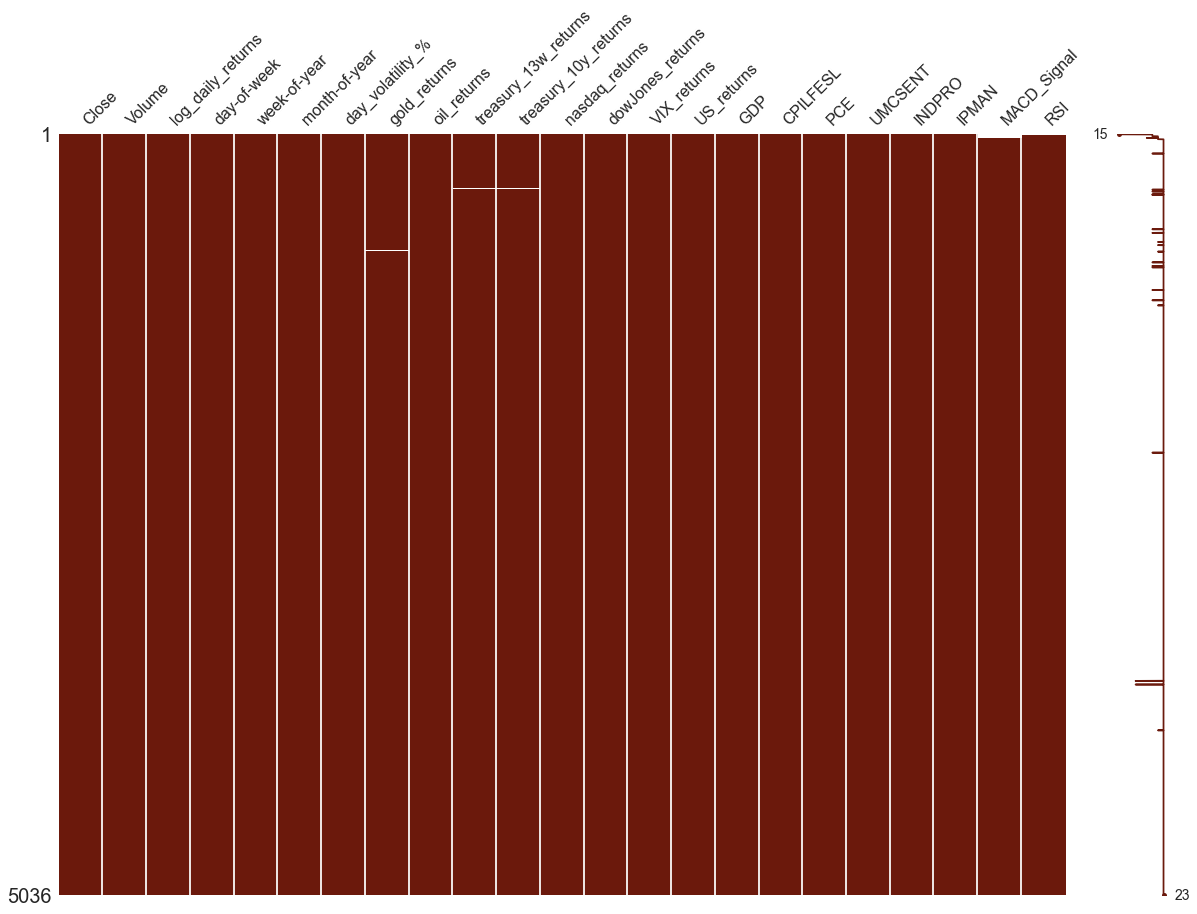

In [60]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=df.iloc[:,2:len(df.columns)], figsize=(20, 14), color=(0.42, 0.1, 0.05))

data = [go.Bar(
            x = train["target"].value_counts().index.values,
            y = train["target"].value_counts().values,
            text='Distribution of target variable'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [61]:
df = df.dropna()

In [62]:
df.isna().sum().sum()

0

# 6. Saving Data Set

In [63]:
from datetime import datetime

In [64]:
from datetime import date

In [65]:
dt = datetime.today()

In [66]:
str(dt)

'2022-12-07 11:22:13.679186'

In [67]:
dt.year

2022

In [68]:
save_name = './DATA_CURATED/DF_CURATED_' + str(dt.year)+'_'+str(dt.month)+'_'+str(dt.day)+'_'+str(dt.hour)+ ".csv"

In [69]:
save_name

'./DATA_CURATED/DF_CURATED_2022_12_7_11.csv'

In [70]:
df.to_csv(save_name, encoding='utf-8')

In [71]:
keys = pd.DataFrame()

In [72]:
keys["keys"] = pd.DataFrame(df.keys())

In [73]:
keys.head(2)

,keys
0,Y_next_daily_returns
1,simple_daily_returns


In [74]:
keys.to_csv(save_name[0:len(save_name)-4] + '_keys.csv', encoding='utf-8')

In [75]:
df

,Y_next_daily_returns,simple_daily_returns,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,...,VIX_returns,US_returns,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN,MACD_Signal,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2002-07-18,-0.038352,-0.026385,881.559998,1736300000,0.026739,3,29,7,0.030888,0.000000,...,-0.002273,-0.000765,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-20.428083,24.627836
2002-07-19,-0.032922,-0.038352,847.750000,2654100000,0.039107,4,29,7,0.046896,0.000000,...,0.048051,0.002408,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-22.343688,21.351079
2002-07-22,-0.027017,-0.032922,819.849976,2248060000,0.033476,0,30,7,0.050255,0.000000,...,0.070023,0.003929,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-24.872814,20.786866
2002-07-23,0.057314,-0.027017,797.700012,2441020000,0.027389,1,30,7,0.039642,0.000000,...,0.062692,0.007462,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-27.915234,20.657899
2002-07-24,-0.005620,0.057314,843.429993,2775560000,-0.055732,2,30,7,0.088490,0.000000,...,-0.172514,-0.007244,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-30.291201,31.330634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,-0.000370,0.013862,3973.750000,4420030000,-0.013767,0,21,5,0.018634,0.000812,...,-0.017253,-0.009221,0.020533,0.006314,0.006748,-0.104294,-0.001019,-0.004148,-104.472357,39.557946
2022-05-24,0.012505,-0.000370,3941.479980,4923190000,0.000370,1,21,5,0.020786,0.006802,...,0.000680,-0.002448,0.020533,0.006314,0.006748,-0.104294,-0.001019,-0.004148,-104.478889,29.468935
2022-05-25,0.018381,0.012505,3978.729980,4802560000,-0.012428,2,21,5,0.018930,0.000000,...,-0.032731,0.002850,0.020533,0.006314,0.006748,-0.104294,-0.001019,-0.004148,-103.189868,38.901348


In [76]:
# Just to see when the code was run for last time
print(datetime.now())

2022-12-07 11:22:14.053200
